In [28]:
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
import pandas as pd

import lifesim
from lifesim.util.radiation import black_body

In [2]:
temp_p = 265.  # in K
radius_p = 1.  # in earth rad
distance_s = 10.  # in pc

temp_s = 5778.  # in K
radius_s = 1.  # in sun rad
lat_s = 0.79  # in rad
z = 3  # in zodis

angsep = 0.1  # in arcsec
integration_time = 55*60*60

In [3]:
bus = lifesim.Bus()

bus.data.options.set_scenario('baseline')

instrument = lifesim.InstrumentPrt(name='inst')
bus.add_module(instrument)

instrument_base = lifesim.Instrument(name='inst_base')
bus.add_module(instrument_base)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst_base', 'transm'))
bus.connect(('inst_base', 'exo'))
bus.connect(('inst_base', 'local'))
bus.connect(('inst_base', 'star'))

bus.connect(('star', 'transm'))

bus.connect(('inst', 'inst_base'))

instrument_base.apply_options()

In [6]:
data=pd.read_csv('/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/30_data/inputs/spectra/Earth_PRTunits_10pc.txt',header=None, sep='\s+')

lam_PRT=data[0].values*u.micron
f_PRT=data[1].values*u.erg/u.cm**2/u.s/u.Hz
f_lifesim = f_PRT.to(u.photon / u.m**2 / u.s / u.micron,\
                      equivalencies=u.spectral_density(lam_PRT))

f_lifesim = f_lifesim.to(u.photon / u.s / u.meter**3)
lam_lifesim = lam_PRT.to(u.meter)

In [7]:
res_in = instrument.get_spectrum(temp_s=temp_s,
                                 radius_s=radius_s,
                                 distance_s=distance_s,
                                 lat_s=lat_s,
                                 z=z,
                                 angsep=angsep,
                                 flux_planet_spectrum=[lam_lifesim, f_lifesim],
                                 integration_time=integration_time)

spectrum, flux_planet, noise = instrument_base.get_spectrum(temp_s=temp_s,
                                                            radius_s=radius_s,
                                                            distance_s=distance_s,
                                                            lat_s=lat_s,
                                                            z=z,
                                                            angsep=angsep,
                                                            flux_planet_spectrum=[lam_lifesim, f_lifesim],
                                                            integration_time=integration_time,
                                                            safe_mode=True)

# snr_in = res_in.loc['signal', 'chop'] / res_in.loc['fundamental', 'chop']
snr_in = res_in.loc[:, 'signal'] / res_in.loc[:, 'noise']

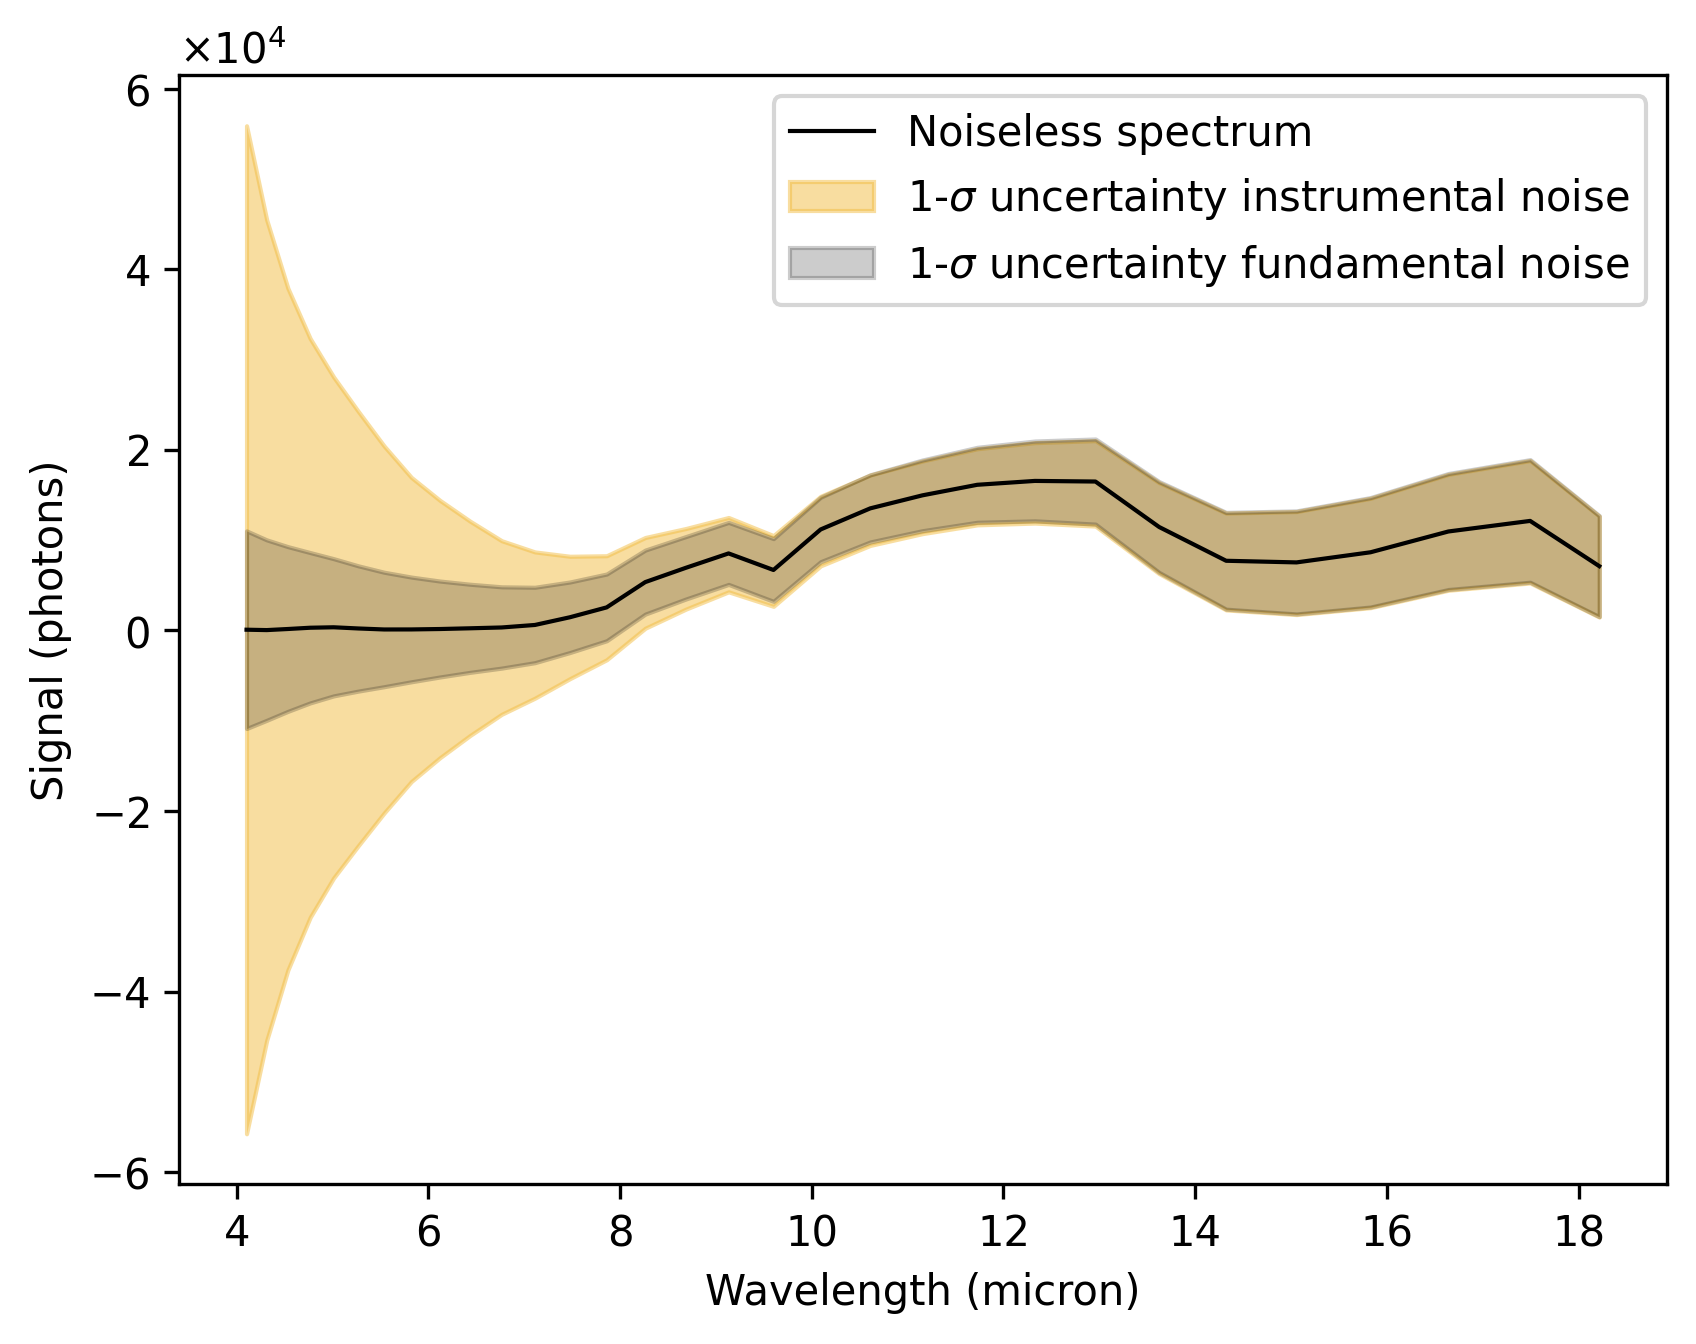

In [30]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

fig, ax = plt.subplots(dpi=300)
ax.ticklabel_format(style='sci')
plt.plot(spectrum[0]*1e6, flux_planet, c='k', lw=1, label='Noiseless spectrum')


plt.fill_between(res_in['wl']*1e6, 
                 res_in['signal']-res_in['signal']/snr_in, 
                 res_in['signal']+res_in['signal']/snr_in,
                color='#F2BD42',
                alpha=0.5, label='1-$\sigma$ uncertainty instrumental noise')

plt.fill_between(spectrum[0]*1e6, 
                 flux_planet-flux_planet/spectrum[1], 
                 flux_planet+flux_planet/spectrum[1],
                color='k',
                alpha=0.2, label='1-$\sigma$ uncertainty fundamental noise')

plt.legend()
plt.xlabel('Wavelength (micron)')
plt.ylabel('Signal (photons)')
ax.yaxis.set_major_formatter(formatter)
plt.show()

In [42]:
(1/(3000*u.cm**-1)).to(u.micron)

<Quantity 3.33333333 micron>